In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import qutip

In [2]:
dev = qml.device('lightning.qubit', wires=3)

In [3]:
N = 400

In [4]:
data = np.random.normal(loc=0,scale=1.5, size=N)

In [5]:
data = data/np.max(np.abs(data))

In [6]:
values, counts = np.histogram(data)

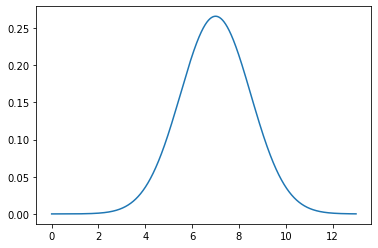

In [7]:
from scipy.stats import norm
x_axis = np.arange(0, 13, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,7,1.5))
plt.show()


Text(0.5, 0, 'i')

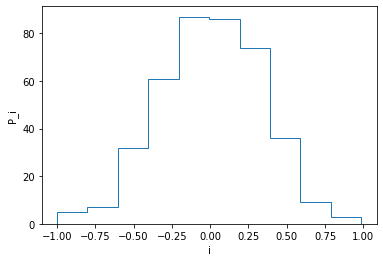

In [8]:
plt.hist(data, histtype='step')#, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')

In [9]:
data = (data+1)*np.pi/2

Text(0.5, 0, 'i')

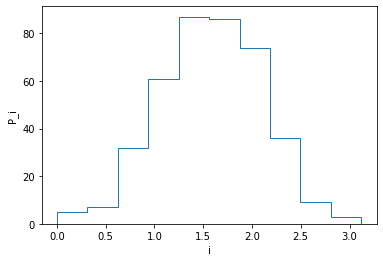

In [10]:
plt.hist(data, histtype='step')#, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')

In [11]:
data_dev = qml.device('lightning.qubit', wires=1)

In [12]:
@qml.qnode(data_dev)
def data_dev_circ(data):
    qml.RY(data, wires=0)
    return qml.expval(qml.PauliZ(0))

(array([ 6.,  6., 11., 20., 21., 27., 30., 24., 31., 27., 38., 28., 23.,
        32., 18., 14., 15., 13.,  9.,  7.]),
 tensor([-9.99789437e-01, -8.99799965e-01, -7.99810493e-01,
         -6.99821021e-01, -5.99831550e-01, -4.99842078e-01,
         -3.99852606e-01, -2.99863134e-01, -1.99873662e-01,
         -9.98841903e-02,  1.05281558e-04,  1.00094753e-01,
          2.00084225e-01,  3.00073697e-01,  4.00063169e-01,
          5.00052641e-01,  6.00042113e-01,  7.00031584e-01,
          8.00021056e-01,  9.00010528e-01,  1.00000000e+00], requires_grad=True),
 <BarContainer object of 20 artists>)

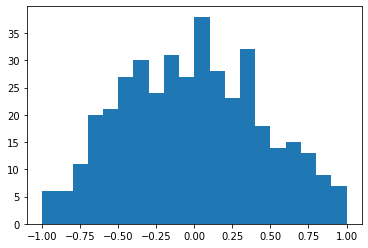

In [13]:
plt.hist(data_dev_circ(data), bins=20)

In [14]:
def G_anastz(z, params):
    layers = int(len(params)/2)
    #qml.Rot(params[0], params[1], params[2], wires=0)
    for i in range(layers): qml.RY(params[i]*z + params[i+layers], wires=0)

In [15]:
def D_ansatz(params):
    qml.RY(params[0],wires=0)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,0])
    qml.RY(params[1],wires=0)
    qml.RY(params[2],wires=1)
    qml.RY(params[3],wires=2)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[2,0])
    qml.RY(params[4],wires=0)
    qml.RY(params[5],wires=1)
    qml.RY(params[6],wires=2)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])

In [16]:
@qml.qnode(dev)
def circuit2(z, params):
    G_anastz(z, params)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_452274/2399309337.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


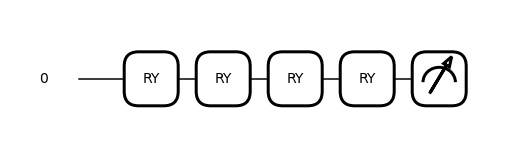

In [17]:
fig, ax = qml.draw_mpl(circuit2)(0.5,np.zeros(shape=8,))
fig.show()

## normal swap

In [18]:
@qml.qnode(dev, diff_method="best")
def training_circ_gen(z, paramsg, paramsd):
    G_anastz(z, paramsg)
    D_ansatz(paramsd)
    return qml.expval(qml.PauliZ(0))

In [19]:
@qml.qnode(dev, diff_method="best")
def training_circ_discr(data, paramsg, paramsd):
    qml.RY(data, wires=0)
    D_ansatz(paramsd)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_452274/3411541928.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


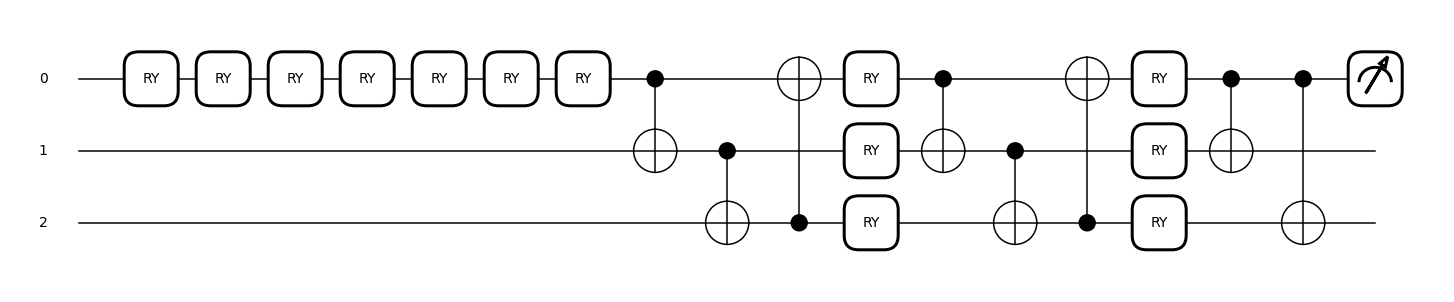

In [20]:
fig, ax = qml.draw_mpl(training_circ_gen)(0.5,np.random.random(size=(12,)), np.random.random(size=(10,)))
fig.show()

## Training 

In [21]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch_old(paramsg, paramsd, batch):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg, paramsd)
        loss = loss + np.log(1 - f)
    return loss / len(batch)

def cost_batch_gen(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    for _ in batch:
        z = np.random.normal(-1, 1, requires_grad=False)
        f = training_circ_gen(z, paramsg, paramsd) 
        f = (1-f)/2
        loss -= np.log(f+reg)
    return loss / len(batch)

def cost_batch_discr(paramsg, paramsd, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        z = np.random.normal(-1, 1, requires_grad=False)
        f1 = training_circ_gen(z, paramsg, paramsd)  
        f2 = training_circ_discr(i, paramsg, paramsd) 
        f1 = (1-f1)/2
        f2 = (1-f2)/2
        loss -= np.log(1-f1+reg)
        loss -= np.log(f2+reg)
    return loss / len(batch)

In [22]:
paramsg = np.random.normal(0,1, size=(40,), requires_grad=True)
paramsd = np.random.normal(-np.pi,np.pi, size=(10,), requires_grad=True)

In [23]:
epochs = 200
batch_size=16
learning_rate=0.01

In [24]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
optd = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

In [25]:
@qml.qnode(dev)
def sample_test_b(z):
    G_anastz(z, paramsg)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]

b = qutip.Bloch()

def plot_bloch_sample():
    pnts = []
    for i in range(N):
        z = np.random.uniform(-1,1)
        vs = sample_test_b(z)
        pnts += [vs]
    pnts = np.array(pnts)
    b.clear()
    b.add_points([pnts[:,0],pnts[:,1],pnts[:,2]])
    b.save(dirc='imgs') 
    #b.show()

In [ ]:
print("initial paramsg:", paramsg)

paramsg_before = paramsg.copy()

losshistg = []
losshistd = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        if it % 2 == 0:
            cost_fn_g = lambda p: cost_batch_gen(p, paramsd, Xbatch)
            paramsg = optg.step(cost_fn_g, paramsg)
        if it % 2 == 1:
            cost_fn = lambda p: cost_batch_discr(paramsg, p, Xbatch)
            paramsd = optd.step(cost_fn, paramsd)
        #plot_bloch_sample()
        print(j, end="\r")
        #if j % 20 == 0:
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} |")
    
    lossg = cost_batch_gen(paramsg, paramsd, data)
    lossd = cost_batch_discr(paramsg, paramsd, data)
    
    losshistg += [lossg]
    losshistd += [lossd]
    
    print("____")
    print(f"Epoch: {it} | Loss gen: {lossg:.3} | Loss discr: {lossd:.3} ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)

initial paramsg: [-0.39875652 -0.56709189  2.23014641  1.08883185  0.9496406   0.97741352
 -1.86017599  1.03976473  0.09293515  0.89949952  1.32067294 -1.70977331
 -1.721632    1.03550745 -1.95469281  0.18398375  0.25387358 -0.52103606
 -1.10743701 -2.05965533  1.14160265  0.4801715  -1.1629749  -0.02724112
  0.13515281  0.05265397 -1.76936179  1.08419776 -1.14686356 -0.56951282
 -0.65960566 -0.25800869 -0.54942     1.69609749 -0.04288423 -0.46568686
  0.65151015 -1.18967193 -0.69311935  0.46153068]
____
Epoch: 0 | Loss gen: 0.724 | Loss discr: 1.64 
____
____
Epoch: 1 | Loss gen: 0.89 | Loss discr: 1.26 
____
____
Epoch: 2 | Loss gen: 0.341 | Loss discr: 1.78 
____
____
Epoch: 3 | Loss gen: 0.693 | Loss discr: 1.25 
____
____
Epoch: 4 | Loss gen: 0.446 | Loss discr: 1.54 
____
____
Epoch: 5 | Loss gen: 0.742 | Loss discr: 1.43 
____
____
Epoch: 6 | Loss gen: 0.74 | Loss discr: 1.43 
____
____
Epoch: 7 | Loss gen: 0.733 | Loss discr: 1.42 
____
____
Epoch: 8 | Loss gen: 0.728 | Loss di

In [ ]:
plt.plot(losshistg)
plt.plot(losshistd)
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
@qml.qnode(dev)
def sample_test(z):
    G_anastz(z, paramsg)
    return qml.expval(qml.PauliZ(0))

In [ ]:
fig, ax = qml.draw_mpl(sample_test)(0.5)
fig.show()

In [ ]:
testresult = []
for i in range(N):
    z = np.random.uniform(-1,1)
    testresult += [sample_test(z)]

In [ ]:
plt.hist(testresult)